# BAB 1 Perkenalan

## 1.1. Identitas

Nama : Ma'ruf Habibie Siregar  
Batch : HCK028  
Program ini dibuat untuk membantu petugas inspeksi asuransi dalam mengautomasi penetapan tingkat keparahan pada mobil konsumen berdasarkan gambar yang di upload oleh konsumen.  
Link Deployment : [Deployement](https://huggingface.co/spaces/batakjawa/Crash_Car_Class)

## 1.2. Latar Belakang dan Problem Statement

### A. Latar Belakang

Dalam industri asuransi, proses inspeksi kerusakan kendaraaan oleh petugas inspeksi masih dilakukan secara manual. Proses itu memerlukan waktu yang relatif lama dan ketidakakuratan karena subjektif, dimana hal-hal ini bisa menurukan kepuasan pelanggan. Contohnya dalam web web asuransi seperti disini [source](https://www.asuransiastra.com/garda-oto/) semuanya masih dilakukan secara manual. Bisa dilihat dari bagian 'Prosedur Klaim Garda Oto', dimana ada surveyor manual pemeriksaan kendaraan. 

Untuk mengatasi masalah tersebut diperlukan  sistem otomatis yang dapat memprediksi klasifikasi tingkat kerusakan mobil. Jadi kerusakan itu bisa terdeteksi dari gambar yang di unggah oleh pemilik mobil. Sistem ini berguna untuk mengotomasi proses inspeksi sehingga dapat mempercepat pengambilan keputusan, mengurangi beban petugas inspeksi asuransi dan meningkatkan akurasi penilaian pada kerusakan. Pengguna sistem ini adalah si pemilik mobil yang mengajukan klaim asuransi dan petugas inspeksi asuransi.

### B. Problem Statement

Membuat sistem berbasis deep learning untuk mengotomasi klasifikasi tingkat kerusakan kendaraan dari gambar, guna mempercepat proses inspeksi klaim asuransi, mengurangi ketergantungan pada pemeriksaan manual, dan meningkatkan akurasi penilaian kerusakan.

# BAB 2 Import Libraries

Pada tahap ini saya akan melakukan import libraries atau packages yang diperlukan untuk exploratory data analisis dan untuk pembuatan model.

In [17]:
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg
import numpy as np
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray
from tensorflow.keras import layers, models
import cv2
import pandas as pd
import seaborn as sns
import tensorflow.keras.backend as K
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50V2

# BAB 3 Data Loading

Pada tahap ini saya akan melakukan pengambilan data. Datanya sudah saya upload di 'kaggle/input' di notebook ini

Sebelum memulai run semuanya saya akan menetapkan SEED, dimana ini bertujuan membuat hasil randomnya lebih konsisten. Jadi hasilnya ngk akan jauh berbeda kalau di run ulang. Seed yang saya pakai adalah 42. Lalu saya juga menggunakan PHTYONHASHSEED untuk mestabilkan urutan data yang biasanya bisa berubah karena Python suka ‘acak-acak’ struktur data. Lalu TF_DETERMINISTIC_OPS agar hasilnya juga tetep konsisten.

In [18]:
SEED = 42

# Set seed untuk semua modul yang pakai randomness
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'  #Supaya hasilnya tetep sama
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [19]:
# Melihat isi folder pada dataset training dan validation
!ls /kaggle/input/crash-car-dataset/data3a/training
!ls /kaggle/input/crash-car-dataset/data3a/validation

01-minor  02-moderate  03-severe
01-minor  02-moderate  03-severe


Dari dataset diatas bisa dilihat ada 3 kelas, yaitu 
1. **01-minor**  =  kerusakan ringan  
2. **02-moderate** = kerusakan sedang/biasa  
3. **03-severe** = kerusakan parah

___________________________________________________________________________________________________________________________________________________
Disini saya akan melakukan penghapusan directory di /kaggle/working yang bertujuan untuk :  
1. Supaya tidak ada data lain di dalamnya, atau duplikat yang bisa menyebabkan banyak masalah
2. Supaya kalau terjadi error saat proses pembuatan model dll, bisa ulang dengan data yang bersih
3. Memastikan folder kaggle/working bersih

In [20]:
#Menghapus directory di kaggle/working
dir_path = '/kaggle/working/crash-car-dataset'

if os.path.exists(dir_path):
    shutil.rmtree(dir_path)
    print(f"Direktori '{dir_path}' dan isinya berhasil dihapus.")
else:
    print("Direktori tidak ditemukan.")

Direktori '/kaggle/working/crash-car-dataset' dan isinya berhasil dihapus.


___________________________________________________________________________________________________________________________________________________
Setelah pembersihan directory di kaggle/working saya akan copy file dataset dari kaggle/input ke kaggle/working. Hal itu saya lakukan karena pada kaggle/input cuma bisa dilakukan 'read', dimana filenya tidak bisa di modifikasi.

In [21]:
#Copy dataset ke 'kaggle/work' 
src_dir = '/kaggle/input/crash-car-dataset/data3a'
dst_dir = '/kaggle/working/crash-car-dataset/data3a'

if not os.path.exists(dst_dir):
    shutil.copytree(src_dir, dst_dir)
    print("Copy dataset selesai.")
else:
    print("Folder sudah ada di working directory.")

Copy dataset selesai.


___________________________________________________________________________________________________________________________________________________
Setelah melakukan copy dataset, saya akan melakukan split data train ke data train dan data test, dimana data test ini akan saya gunakan untuk inference model. Saya akan membaginya menjadi 90 % Data Train dan 10% Data Test

In [22]:
# Split Data Train to Data Train and Data Test

train_dir = '/kaggle/working/crash-car-dataset/data3a/training'
test_dir = '/kaggle/working/crash-car-dataset/data3a/test'

# Buat folder test jika belum ada
os.makedirs(test_dir, exist_ok=True)

# Ambil list kelas(subfolder) dari training
classes = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

for cls in classes:
    cls_train_dir = os.path.join(train_dir, cls)
    cls_test_dir = os.path.join(test_dir, cls)
    os.makedirs(cls_test_dir, exist_ok=True)  # buat subfolder class untuk test

    # List seluruh file di folder kelas training
    all_images = [f for f in os.listdir(cls_train_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Split test dengan proporsi 10%
    train_files, test_files = train_test_split(all_images, test_size=0.10, random_state=42)

    # Pindahkan file test dari training ke folder test
    for file_name in test_files:
        src_path = os.path.join(cls_train_dir, file_name)
        dst_path = os.path.join(cls_test_dir, file_name)

        shutil.move(src_path, dst_path)

print("Split Data Test selesai, folder test sudah dibuat.")

Split Data Test selesai, folder test sudah dibuat.


--------------------------------------------------------------------------------------------------------------------------------------------------
Setelah melakukan split data, saya akan melakukan loading data, dimana saya akan resize secara virtual gambar-gambarnya pada data-train, data-val dan data-test. Pada loading data ini saya menggunakan ****image_dataset_from_directory**** dari ****TensorFlow_Keras****.  
Parameter yang saya gunakan adalah  
1. ****label_mode = 'int'**** supaya kategori pada kelas tersusun secara ordinal dimana 01-minor = 0, 02-moderate = 1, dan 03-severe = 2
2. ****batch_size = None**** supaya gambarnya bisa di augmentasi berdasarkan EDA yaitu augmentasi noise dan texture (gaussian blur, gaussian nouse, random_cutout)
3. ****shuffle**** = true/false dimana pada ***data training*** = ***true*** supaya model tidak belajar secara berurut. Lalu untuk ***data validation dan data test = false*** supaya model bisa di evaluasi secara konsisten dan apa adanya.
4. ****image_size= (224,224)**** supaya ukuran gambarnya sama karena beberapa model seperti CNN memerlukan input gambar dengan dimensi yang sama agar training berjalan lancar

In [23]:
# Load data dan resize gambar saat loading
base_dir = '/kaggle/working/crash-car-dataset/data3a'
train_dir = '/kaggle/working/crash-car-dataset/data3a/training'
val_dir = '/kaggle/working/crash-car-dataset/data3a/validation'
test_dir = '/kaggle/working/crash-car-dataset/data3a/test'

#load data train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir + '/training',
    label_mode='int',
    image_size=(224, 224),  # Resize gambar ke 224x224
    batch_size=None,           
    shuffle=True,
    seed=SEED
)

#load data val
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir + '/validation',
    label_mode='int',
    image_size=(224, 224),
    batch_size=None,
    shuffle=False,
)

#load data test
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir + '/test',
    label_mode='int',
    image_size= (224, 224),  # Resize pas loading
    batch_size=None,
    shuffle=False
)

print("Classes (TensorFlow):", train_ds.class_names)

for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape) 
    print("Labels:", labels.numpy())


Found 1243 files belonging to 3 classes.
Found 248 files belonging to 3 classes.
Found 140 files belonging to 3 classes.
Classes (TensorFlow): ['01-minor', '02-moderate', '03-severe']
Image batch shape: (224, 224, 3)
Labels: 2


Dari info diatas terlihat bahwa :  
1. Data Train ada 1243 gambar
2. Data Validation ada 248 gambar
3. Data Test ada 140 gambar
4. Nama class sudah sesuai yaitu : 01-minor  02-moderate  03-severe
5. Di dalam data train sudah ada Gambar dengan ukuran 224 x 224, dimana warnanya adalah RGB (3)

___________________________________________________________________________________________________________________________________________________
Setelah data loading saya akan melihat distribusi class pada tiap dataset (data train, data validation dan data test)

In [24]:
#Cek distribusi tiap label

base_dir = '/kaggle/working/crash-car-dataset/data3a'
folders = ['training', 'validation', 'test']
class_names = ['01-minor', '02-moderate', '03-severe']

for folder in folders:
    '''Looping untuk mengecek distribusi kelas minor, moderate dan severe di tiap dataset (training, validation dan test)'''
    print(f"Distribusi di {folder}:")
    for cls in class_names:
        cls_dir = os.path.join(base_dir, folder, cls)
        count = len(os.listdir(cls_dir))
        print(f"  {cls}: {count} images")
    print()

Distribusi di training:
  01-minor: 406 images
  02-moderate: 416 images
  03-severe: 421 images

Distribusi di validation:
  01-minor: 82 images
  02-moderate: 75 images
  03-severe: 91 images

Distribusi di test:
  01-minor: 46 images
  02-moderate: 47 images
  03-severe: 47 images



Dari hasil pengecekan distribusi di atas saya simpulkan data-datanya terdistribusi dengan baik, dimana tidak ada ketimpangan yang signifikan antara tiap kelas.

# BAB 4 Exploratory Data Analysis (EDA)

Pada tahap ini saya akan melakukan beberapa eksplorasi data. Tahap ini bertujuan untuk membuat saya memahami apa ciri-ciri yang diperlukan untuk membedakan 3 kelas di dataset ini.

## 4.1. Melihat sample gambar tiap kelas

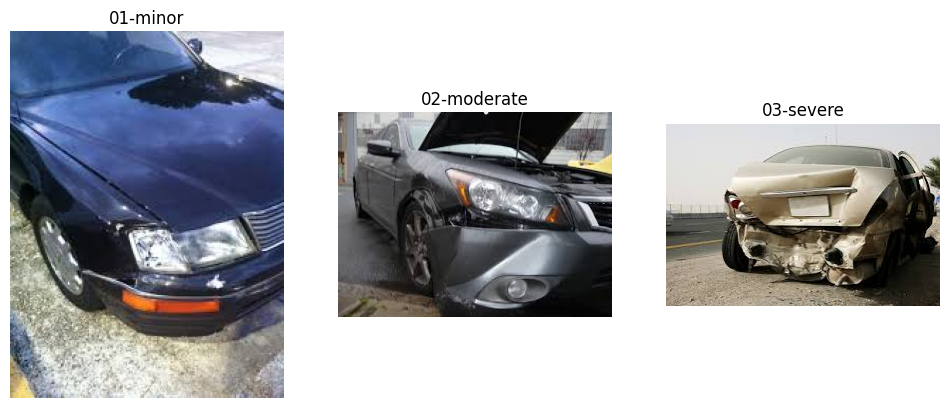

In [12]:
# Melihat sampel dari tiap kelas di data train

class_names = ['01-minor', '02-moderate', '03-severe']

plt.figure(figsize=(12, 6))

for i, nama_kelas in enumerate(class_names):
    folder_kelas = os.path.join(train_dir, nama_kelas)
    # Mengambil 1 gambar secara acak di tiap label/kelas
    nama_gambar = random.choice(os.listdir(folder_kelas))
    path_gambar = os.path.join(folder_kelas, nama_gambar)
    # Baca gambarnya pake mpimg
    gambar = mpimg.imread(path_gambar)
    
    plt.subplot(1, 3, i + 1)
    plt.imshow(gambar)
    plt.title(nama_kelas)
    plt.axis('off') #supaya tidak ada axis x dan y

plt.show()


Dari sampel gambar di atas bisa saya simpulkan  ada perbedaan yang sangat signifikan dari kerusakan mobil pada tiap kelas.

## 4.2. Melihat rata-rata ukuran gambar pada tiap kelas

In [15]:
#Melihat rata-rata ukuran gambar pada tiap kelas di data training, validation dan test
def average_image_size_from_subfolders(base_dir):
    widths = []
    heights = []
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')

    # Telusuri setiap subfolder di dalam base_dir
    for root, dirs, files in os.walk(base_dir):
        for filename in files:
            if filename.lower().endswith(valid_extensions):
                file_path = os.path.join(root, filename)
                img = cv2.imread(file_path)
                if img is not None:
                    h, w = img.shape[:2]
                    heights.append(h)
                    widths.append(w)
                else:
                    print(f'File {filename} di {root} tidak bisa dibaca sebagai gambar.')
            else:
                print(f'File {filename} di {root} diabaikan karena bukan ekstensi gambar yang valid.')

    avg_width = np.mean(widths) if widths else 0
    avg_height = np.mean(heights) if heights else 0
    return avg_width, avg_height

base_dir = '/kaggle/working/crash-car-dataset/data3a'
train_dir = os.path.join(base_dir, 'training')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

print('Rata-rata ukuran gambar asli di folder:')
print('Training:', average_image_size_from_subfolders(train_dir))
print('Validation:', average_image_size_from_subfolders(val_dir))
print('Test:', average_image_size_from_subfolders(test_dir))


Rata-rata ukuran gambar asli di folder:
Training: (247.49959774738537, 178.31456154465005)
Validation: (236.39112903225808, 171.11693548387098)
Test: (239.35, 176.67857142857142)


Dari hasil diatas rata-rata gambarnya adalah :
- Data Training: sekitar (247.5 x 178.3)
- Data Validation: sekitar (236.4 x 171.1)
- Data Test: sekitar (239.3 x 176.7)

## 4.3. Melihat ciri-ciri gambar berdasarkan darkspot (area gelap)

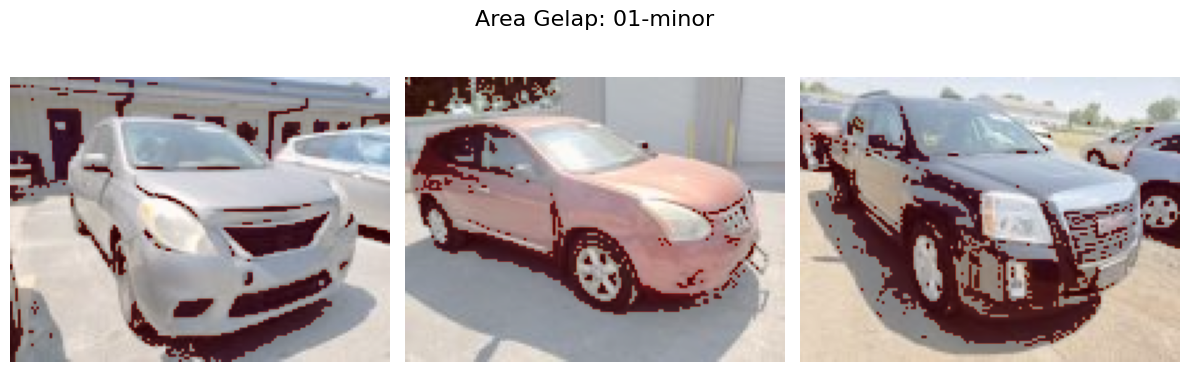

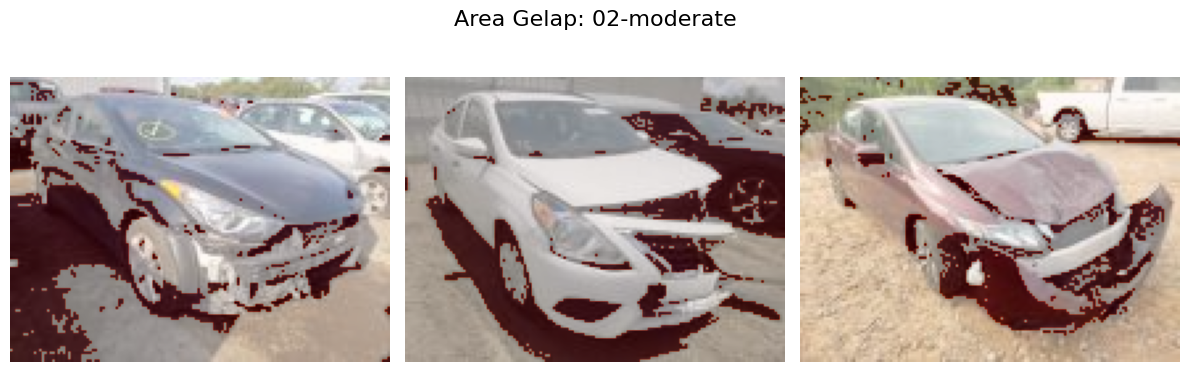

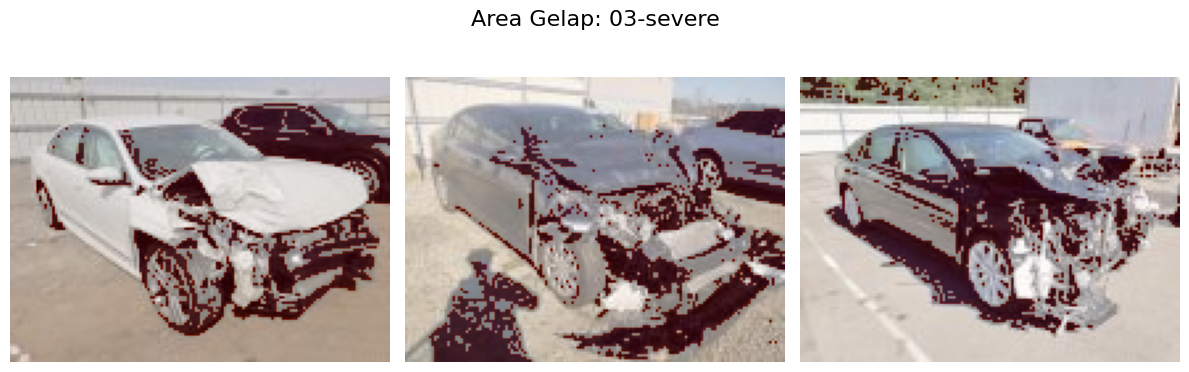

In [45]:
#Visualisasi area gelap pada tiap kelas


# Load gambar dan label
images, labels = [], []
for i, cls in enumerate(classes):
    folder = os.path.join(train_dir, cls)
    for f in os.listdir(folder):
        if f.lower().endswith(('.jpg', '.png')):
            img = cv2.imread(os.path.join(folder, f))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
            labels.append(i)

images = np.array(images)
labels = np.array(labels)

# Fungsi deteksi area gelap sederhana
def dark_area_mask(img, thresh=50):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return (gray <= thresh).astype(float)  # float supaya alpha bisa dipakai

# Visualisasi overlay area gelap untuk n sampel tiap kelas
def visualize_overlay(images, labels, class_names, n=3):
    np.random.seed(42)
    for c, name in enumerate(class_names):
        idxs = np.where(labels == c)[0]
        sample = np.random.choice(idxs, min(n, len(idxs)), replace=False)
        fig, ax = plt.subplots(1, len(sample), figsize=(12,4))
        fig.suptitle(f'Area Gelap: {name}', fontsize=16)
        if len(sample) == 1:
            ax = [ax]
        for a, i in zip(ax, sample):
            a.imshow(images[i])
            a.imshow(dark_area_mask(images[i]), cmap='Reds', alpha=0.4)
            a.axis('off')
        plt.tight_layout()
        plt.show()

# Panggil fungsi visualisasi
visualize_overlay(images, labels, class_names, n=3)


Insight dari visualisasi diatas :  

1. Area gelap tidak bisa jadi ciri kerusakan dan tidak bisa membedakan secara spesifik pada tiap kelas
   Itu bisa jadi karena area gelap masuk ke dalamnya bayangan, bagian bawah mobil, atau pencahayaan (lighting) yang tidak konsisten
2. Pemisahan kelas berdasarkan area gelap juga dipengaruhi banyak faktor eksternal seperti background dan lain-lain yang membuat kurang efektif

## 4.4. Melihat ciri-ciri gambar tiap kelas berdasarkan Noise

Karena area gelap tidak terlalu bisa membedakan kelas secara visual, saya akan coba dengan membedakannya berdasarkan noise. Karena secara logika, kerusakan yang parah pasti noisenya besar. Layaknya seperti gambar abstrak yang mempunyai noise yang sangat besar dibandingkan gambar normal karena gambar abstrak polanya acak atau bisa dibilang coretan pelukisnya tidak ada polanya. Noise juga bisa dibilang sebagai fluktuasi (perubahan) acak pada warna dan brightness(kecerahan) atau bisa juga karena perubahan intensitas pixel yang mendadak, misalkan tiba-tiba dari 1 pixel ke pixel lain (dari pixel 0 tiba-tiba 255 trus tiba-tiba ke 4 dan seterusnya). [source](https://www.cambridgeincolour.com/tutorials/image-noise.htm)

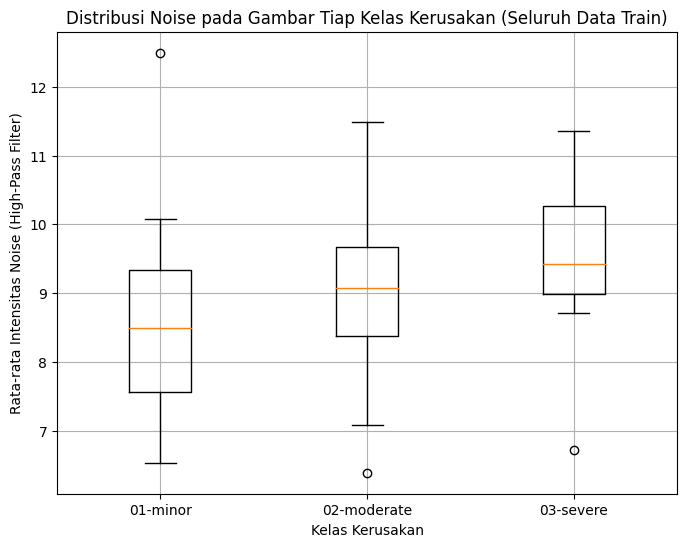

In [46]:
# Fungsi filtering high-pass sederhana dengan Laplacian filter
def high_pass_filter(image_gray):
    return cv2.Laplacian(image_gray, cv2.CV_64F)

# Fungsi komputasi noise metric dari path gambar
def compute_noise_metric(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224, 224))
    noise_img = high_pass_filter(img)
    noise_abs = np.abs(noise_img)
    noise_metric = noise_abs.mean()
    return noise_metric

train_dir = '/kaggle/working/crash-car-dataset/data3a/training'
classes = ["01-minor", "02-moderate", "03-severe"]

results = {}

for cls in classes:
    class_path = os.path.join(train_dir, cls)
    noise_values = []
    
    # Ambil semua gambar .jpg dan .png di folder kelas tanpa batasi jumlah
    img_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png'))]
    
    for img_file in img_files:
        img_path = os.path.join(class_path, img_file)
        noise_val = compute_noise_metric(img_path)
        noise_values.append(noise_val)
    
    results[cls] = noise_values

# Visualisasi distribusi noise per kelas
plt.figure(figsize=(8,6))
plt.boxplot([results[cls] for cls in classes], labels=classes)
plt.title("Distribusi Noise pada Gambar Tiap Kelas Kerusakan (Seluruh Data Train)")
plt.ylabel("Rata-rata Intensitas Noise (High-Pass Filter)")
plt.xlabel("Kelas Kerusakan")
plt.grid(True)
plt.show()


Berdasarkan boxplot distribusi noise di peroleh beberapa insight, yaitu :    

1. Median noise pada gambar terlihat meningkat berbanding lurus dengan tingkat kerusakan, dimana kelas severe menampilkan noise yang cukup tinggi  
2. Terdapat outliers noise besar pada kelas minor, bisa jadi bukan karena kerusakan yang besar tapi pencahayaan yang kurang, bisa juga karena kualitas gambar (sensor kamera)
3. Di kelas moderate ada variasi noise yang hampir sama dengan kelas severe dan kelas minor, itu menjadikan kelas moderate ada yang kerusakannnya mendekati sever dan mendekati minor.
4. Banyak faktor teknis sebenarnya dalam masalah noise, seperti kualitas gambar, pencahayaan dan lain-lain
5. Untuk lebih jelas, saya akan melihat contoh outliers dari beberapa kelas.


Outlier pada kelas 01-minor (total 1 gambar):


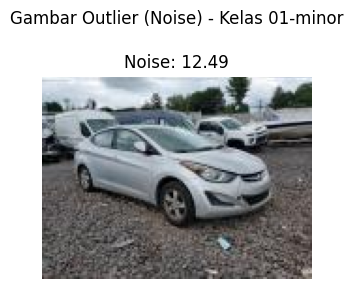


Outlier pada kelas 02-moderate (total 1 gambar):


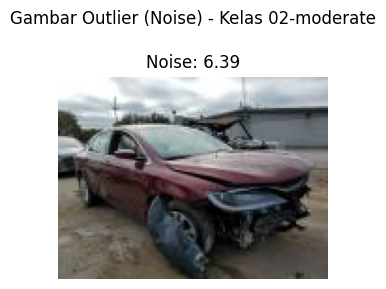


Outlier pada kelas 03-severe (total 1 gambar):


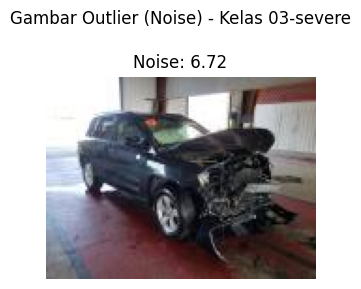

In [48]:
#Melihat contoh outliers

# Fungsi filtering high-pass sederhana dengan Laplacian filter
def high_pass_filter(image_gray):
    return cv2.Laplacian(image_gray, cv2.CV_64F)

# Fungsi komputasi noise metric dari path gambar
def compute_noise_metric(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224, 224))
    noise_img = high_pass_filter(img)
    noise_abs = np.abs(noise_img)
    noise_metric = noise_abs.mean()
    return noise_metric

train_dir = '/kaggle/working/crash-car-dataset/data3a/training'
classes = ["01-minor", "02-moderate", "03-severe"]

# Simpan path dan noise value
results = {}
images_paths = {}

for cls in classes:
    class_path = os.path.join(train_dir, cls)
    noise_values = []
    img_paths = []
    
    img_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png'))]
    
    for img_file in img_files:
        img_path = os.path.join(class_path, img_file)
        noise_val = compute_noise_metric(img_path)
        noise_values.append(noise_val)
        img_paths.append(img_path)
    
    results[cls] = noise_values
    images_paths[cls] = img_paths

# Fungsi mencari outlier menggunakan metode IQR
def find_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_indices = [i for i, v in enumerate(data) if v < lower_bound or v > upper_bound]
    return outlier_indices

# Tampilkan gambar outlier
def show_outlier_images(results, images_paths, classes):
    for cls in classes:
        noise_vals = results[cls]
        outlier_idx = find_outliers(noise_vals)
        print(f"\nOutlier pada kelas {cls} (total {len(outlier_idx)} gambar):")
        
        n_outliers = len(outlier_idx)
        if n_outliers == 0:
            print("Tidak ada outlier pada kelas ini.")
            continue
        
        cols = min(n_outliers, 5)
        rows = (n_outliers // cols) + (1 if n_outliers % cols > 0 else 0)
        plt.figure(figsize=(3*cols, 3*rows))
        for i, idx in enumerate(outlier_idx):
            img_path = images_paths[cls][idx]
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            noise_val = noise_vals[idx]
            
            plt.subplot(rows, cols, i+1)
            plt.imshow(img)
            plt.title(f"Noise: {noise_val:.2f}")
            plt.axis('off')
        
        plt.suptitle(f"Gambar Outlier (Noise) - Kelas {cls}")
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

# Panggil fungsi untuk menampilkan gambar outlier
show_outlier_images(results, images_paths, classes)


Dari hasil gambar di atas bisa saya ambil insight :  

1. Outliers pada kelas minor terjadi karena backgroundnya, background aspal dan banyak mobil cenderung membuat noise besar
2. Outliers pada kelas moderate menunjukkan walaupun kerusakan tergolong sedang akan tetapi luas dan banyak detailnya
3. Outliers pada kelas severe disini noisenya kecil dibandingkan gambar lain di kelasnya. Itu bisa terjadi karena kerusakannya lebih seperti moderate tapi kalau lihat kap mobilnya dan bagian mesin sampai rusak, ini sudah termasuk kategori kelas severe

________________________________________________________________________________________________________________________________________________________________________________
Karena background sangat berpengaruh terhadap noise maka saya akan visualisasikan noisenya dengan isolasi background

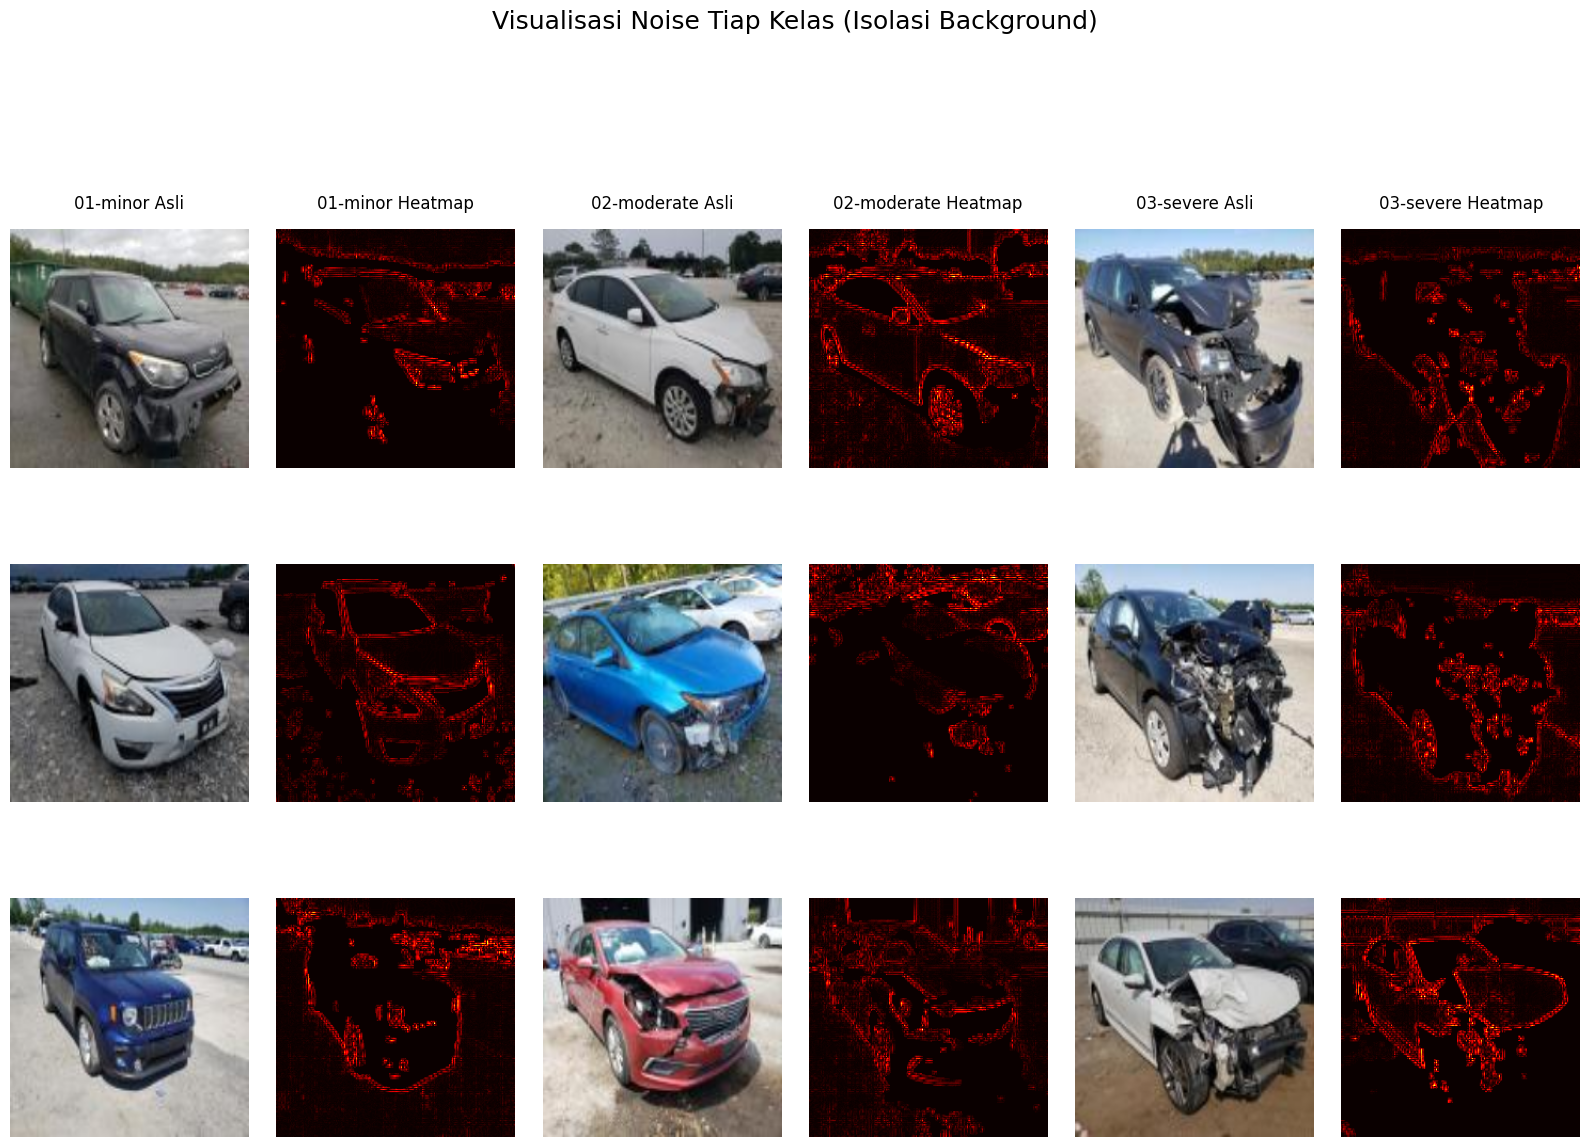

In [19]:
def high_pass_filter(image_gray):
    """Menghasilkan gambar noise dengan high pass filter Laplacian"""
    return cv2.Laplacian(image_gray, cv2.CV_64F)
# high_pass_filter()

def get_foreground_mask(image_gray):
    """Menghasilkan mask boolean isolasi mobil berdasarkan Otsu threshold"""
    _, mask = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=1)
    mask_bool = mask.astype(bool)
    return mask_bool
# get_foreground_mask()

def plot_noise_visualization_isolated(base_dir, classes, num_samples):
    """Plot visualisasi noise heatmap dengan isolasi background pada tiap kelas"""
    plt.figure(figsize=(16, 4 * num_samples))
    
    for cls_idx, cls in enumerate(classes):
        class_path = os.path.join(base_dir, cls)
        img_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png'))][:num_samples]
        
        for i, img_file in enumerate(img_files):
            img_path = os.path.join(class_path, img_file)
            img = cv2.imread(img_path)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img_gray = cv2.resize(img_gray, (224, 224))
            img_color = cv2.resize(img, (224, 224))
            
            mask = get_foreground_mask(img_gray)
            
            noise_img = high_pass_filter(img_gray)
            noise_abs = np.abs(noise_img)
            
            noise_mobil = np.zeros_like(noise_abs)
            noise_mobil[mask] = noise_abs[mask]
            
            if noise_mobil[mask].size > 0:
                noise_norm = np.zeros_like(noise_mobil)
                norm_val = noise_mobil[mask]
                noise_norm[mask] = (norm_val - norm_val.min()) / (norm_val.max() - norm_val.min() + 1e-10)
            else:
                noise_norm = noise_mobil
            
            # Plot gambar asli
            plt.subplot(num_samples, len(classes)*2, i*(len(classes)*2) + cls_idx*2 + 1)
            plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            if i == 0:
                plt.title(f"{cls} Asli", fontsize=12, pad=15)
            
            # Plot heatmap noise isolasi mobil
            plt.subplot(num_samples, len(classes)*2, i*(len(classes)*2) + cls_idx*2 + 2)
            plt.imshow(noise_norm, cmap='hot')
            plt.axis('off')
            if i == 0:
                plt.title(f"{cls} Heatmap", fontsize=12, pad=15)
    
    plt.suptitle("Visualisasi Noise Tiap Kelas (Isolasi Background)", fontsize=18, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.95], h_pad=2, w_pad=2)
    plt.show()
# plot_noise_visualization_isolated()

# Contoh pemanggilan fungsi
train_dir = '/kaggle/working/crash-car-dataset/data3a/training'
classes = ["01-minor", "02-moderate", "03-severe"]
plot_noise_visualization_isolated(train_dir, classes, num_samples=3)


Dari gambar-gambar hasil heatmap noise diatas bisa saya ambil insight :  

1. Pada kelas 01-minor, area noise terlihat lebih sedikit dan tersebar secara tipis pada batas kerusakan 
2. Pada kelas 02-moderate, noise lebih banyak dan area heatmap lebih luas terutama di sekitar area benturan.
3. Pada kelas 03-severe, heatmap noise terlihat lebih kuat lagi, dengan area yang luas dan tebal, itu mencerminkan tingkat kerusakan yang sangat parah dengan detail noise tinggi.

Dari poin poin diatas bisa diindikasikan bahwa saya bisa menggunakan metode visualiasi noise dengan isolasi background untuk membedakan tiap kelas, akan teapi memang tidak terlalu kuat terutama kalau ada faktor-faktor lain seperti pencahayaan yang kurang atau gambar yang kurang tajam yang menyebabkan noisenya besar walaupun itu kelas minor atau moderate.

## 4.4. Melihat visualiasi perbedaan kelas menggunakan Kontur dan Tektur

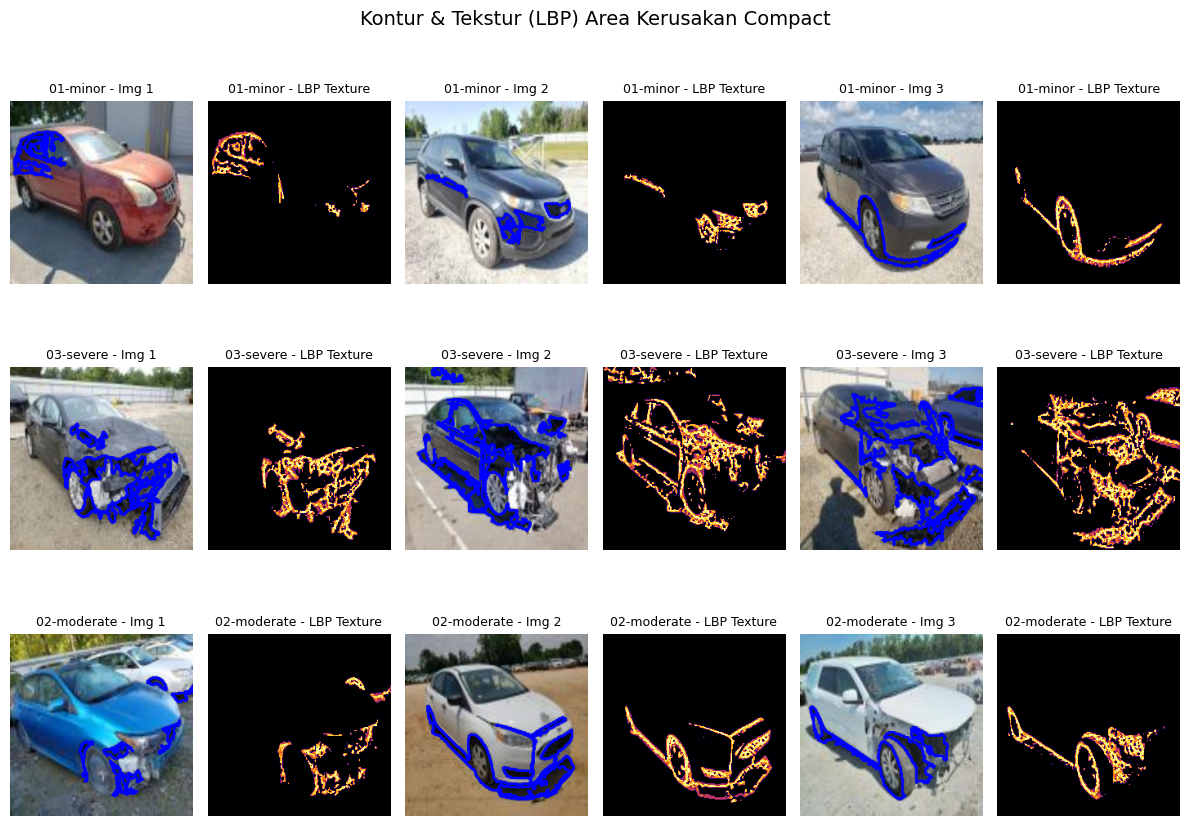

In [10]:
#Mem-visualiasi bentuk pada area kerusakan mobil

def plot_damage_contours_texture_lbp_compact(base_dir, classes, num_samples):
    radius = 3
    n_points = 8 * radius  # jumlah titik tetangga
    
    # Tentukan ukuran figure yang lebih compact dengan 2 kolom per gambar (img + lbp)
    fig, axes = plt.subplots(len(classes), num_samples * 2, figsize=(num_samples * 4, len(classes) * 3), squeeze=False)
    
    for cls_idx, cls in enumerate(classes):
        class_path = os.path.join(base_dir, cls)
        img_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png'))][:num_samples]

        for i, img_file in enumerate(img_files):
            img_path = os.path.join(class_path, img_file)
            img = cv2.imread(img_path)
            img_resized = cv2.resize(img, (224, 224))
            img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

            # Segmentasi kasar area mobil via adaptive threshold
            mask = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                         cv2.THRESH_BINARY_INV, 11, 2)

            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if len(contours) == 0:
                continue

            largest_contour = max(contours, key=cv2.contourArea)
            mask_mobil = np.zeros_like(mask)
            cv2.drawContours(mask_mobil, [largest_contour], -1, 255, thickness=-1)

            # Threshold area kerusakan di dalam area mobil
            _, damage_thresh = cv2.threshold(img_gray, 60, 255, cv2.THRESH_BINARY_INV)
            damage_mask = cv2.bitwise_and(damage_thresh, damage_thresh, mask=mask_mobil)

            contours_damage, _ = cv2.findContours(damage_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contours_filtered = [cnt for cnt in contours_damage if cv2.contourArea(cnt) > 100]

            # Hitung LBP di area mobil
            lbp = local_binary_pattern(img_gray, n_points, radius, method="uniform")
            lbp_norm = (lbp - lbp.min()) / (lbp.max() - lbp.min())

            # Mask LBP pada area kerusakan
            lbp_masked = lbp_norm * (damage_mask / 255.0)

            # Gambar kontur kerusakan pada gambar asli
            img_contour = img_resized.copy()
            cv2.drawContours(img_contour, contours_filtered, -1, (255, 0, 0), 2)

            # Plot gambar asli dengan kontur
            ax_img = axes[cls_idx, i*2]
            ax_img.imshow(cv2.cvtColor(img_contour, cv2.COLOR_BGR2RGB))
            ax_img.set_title(f'{cls} - Img {i+1}', fontsize=9)
            ax_img.axis('off')

            # Plot heatmap LBP area kerusakan
            ax_lbp = axes[cls_idx, i*2 + 1]
            ax_lbp.imshow(lbp_masked, cmap='inferno')
            ax_lbp.set_title(f'{cls} - LBP Texture', fontsize=9)
            ax_lbp.axis('off')

    plt.suptitle("Kontur & Tekstur (LBP) Area Kerusakan Compact", fontsize=14)
    plt.tight_layout()
    plt.show()

#pemanggilan fungsi
plot_damage_contours_texture_lbp_compact(train_dir, classes, num_samples=3)


1. Perbedaan Kontur Kerusakan  
* Minor (ringan): Garis konturnya sedikit dan area yang rusak kecil. Jadi kerusakannya memang nggak terlalu parah. Dan bisa juga terlihat di gambar satu bahwa tidak ada kontur sama sekali, malah background yang terkena garisnya.  
* Moderate (sedang): Garis kontur mulai banyak dan menyebar di beberapa bagian mobil, ini tanda kerusakannya lebih nyata dan cukup banyak.  
* Severe (berat): Kontur kerusakan paling banyak, bentuknya rumit, dan area rusaknya besar. Ini jelas kerusakan sangat parah.
  
2. Pola Tekstur LBP (Hitam)
* LBP ini menegaskan lagi pola kerusakannya
* Minor: Pola teksturnya tidak banyak, karena area rusaknya memang terbatas.
* Moderate dan Severe: Pola tekstur lebih banyak dan beragam, dengan intensitas yang beda-beda, artinya kerusakannya lebih rumit dan merata di banyak bagian.  

Kesimpulan :  
Metode yang kita pakai ini (kontur dan pola tekstur) cukup bagus buat menunjukkan perbedaan kelas tingkat kerusakan mobil. Jadi, data ini bisa dipake sebagai fitur penting untuk model. 



# BAB 5 Feature Engineering

## Data Augmentation, Normalize, dan Batch Generator

Pada tahap ini saya akan melakukan data augmentation dimana ini bertujuan untuk memperbanyak dan memperkaya data training. Augmentation ini membuat versi baru dari beberapa sisi seperti di zoom, translate, rotate dan lain-lain. Augmentation hanya dilakukan di data training karena data validation dan data test harus murni data asli supaya lebih hasilnya lebih realistis di data validation dan data test. Lalu setelah augmentation saya akan melakukan data normalize, dimana ini mengubah rentang pixel dari 0-255 menjadi 0-1 supaya model bisa cepat belajar karena semua gambar/datanya sama skalanya. Setelah itu saya akan melakukan batch generator dimana ini bertujuan untuk memindahkan gambar-gambar menjadi beberapa kelompok sekaligus. Hal ini bertujuan agar pelatihan / training model lebih efisien.

### A.  Data Augmentation

Pada data augmentation saya bagi menjadi dua bagian, yaitu :  
1. Data Augmentation dengan TensorFlow :
   * Flip Horizontal :
     - Saya melakukan flip horizontal secara acak agar sudut kerusakan tidak pada bagian tertentu saja, jadi lebih bervariasi. Misalkan tidak pada bagian kiri saja, karena dengan di flip bisa ada sudut kerusakan di bagian kanan juga
     - Cara ini bertujuan untuk menghindari bias pada satu sudut kerusakan
    * Random Brightness :
      - Data asli pasti variasi kecerahannya berbeda-beda, tergantung dimana pengambilan gambarnya. Di outdoor atau di indoor pasti berbeda, ada tambahan lighting atau tidak juga pasti berbeda.
      - Melakukan perubahan brightness secara acak dengan maksimal delta di 0.1 membantu model melihat dari berbagai kondisi cahaya sehingga tidak bias ke kondisi brightness yang bagus saja.
    * Random Contrast :
      - Layaknya seperti brightness, kontras gambar juga bervariasi tergantung kamera dan kondisi tempat pengambilan gambar/foto.
      - Melakukan random contrast ini membuat model lebih robust pada kondisi nyata dimana kontrasnya tidak selalu sama di tiap gambar/foto.
    * Resize :
      - Ini dilakukan supaya setelah augmentasi ukuran gambarnya tetap pada ukuran yang di tentukan, disini saya menggunakan ukuran 224 x 224.
      - Pada arsitektur model seperti resnet atau effecientNet biasanya memerlukan input yang fix ukurannya
2. Data Augmentation dengan Numphy berdasarkan EDA :
   * Local Binary Pattern (LBP Texture) [source](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_local_binary_pattern.html)
     - LBP digunakan untuk mengekstrak tekstur lokal di gambar dengan mengubah piksel menjadi representasi biner berdasarkan sekitarnya.
     - Cocok untuk membedakan karakteristik kerusakan antar kelas yang cenderung memiliki pola tekstur berbeda.
     - Berdasarkan EDA visual sebelumnya, area kerusakan pada mobil biasanya menghasilkan pola LBP yang lebih padat atau tajam.
   * Heatmap dari Deteksi Tepi (Edge Detection)[source](https://docs.opencv.org/4.x/d5/db5/tutorial_laplace_operator.html) 
     - Menggunakan operator Laplacian untuk mendeteksi perubahan intensitas pada gambar grayscale.
     - Hasil deteksi tepi tersebut kemudian diwarnai dengan colormap (seperti jet), membentuk heatmap kontur kerusakan.
     - Heatmap ini mempertegas bentuk kerusakan dan membuat model lebih fokus pada area yang penting.
   * High-Pass Filter Lapician (filter untuk tepi garis gambar) :  [source](https://docs.opencv.org/4.x/d5/db5/tutorial_laplace_operator.html)
      - Berdasarkan box-plot intensitas noise pada EDA, bisa dilihat kalau pada kelas ***severe*** dan ***moderate*** mempunyai noise yang lebih tinggi dari kelas ***minor***
      - Jadi fungsi filter ini adalah menonjolkan garis tepi dan tekstur pada area kerusakan mobil
      - Augmentasi disini juga bertujuan untuk membedakan karakteristik texture pada tiap kelas
   * Transformasi Warna dan Size :
      - Melakukan transformasi brightness dan contrast seperti pada Data Augmentasi tensorflow, supaya lebih bervariasi lagi gambarnya.
      - Melakukan transformasi size lagi ke ukuran 224 x 224 supaya ukuran tetap di angka tersebut setelah di augmentasi high pass, gaussian noise, blur dan random cutout.
      

In [25]:
# Aktifkan numpy behavior
tf.experimental.numpy.experimental_enable_numpy_behavior()

# Augmentasi TensorFlow
def augment_tf(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, 0.9, 1.1)
    image = tf.image.resize(image, (224, 224))
    return image, label


# LBP Texture Area Kerusakan
def apply_lbp_tf(image, label):
    def apply_lbp_damage_only(image_np):
        image_np = image_np.numpy().astype(np.uint8)
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        radius = 3
        n_points = 8 * radius
        lbp = local_binary_pattern(gray, n_points, radius, method="uniform")
        lbp_norm = (lbp - lbp.min()) / (lbp.max() - lbp.min())

        mask_mobil = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                           cv2.THRESH_BINARY_INV, 11, 2)
        contours, _ = cv2.findContours(mask_mobil, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        mask_draw = np.zeros_like(mask_mobil)
        if contours:
            largest = max(contours, key=cv2.contourArea)
            cv2.drawContours(mask_draw, [largest], -1, 255, -1)

        _, damage_thresh = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY_INV)
        damage_mask = cv2.bitwise_and(damage_thresh, damage_thresh, mask=mask_draw)
        lbp_masked = lbp_norm * (damage_mask / 255.0)

        lbp_vis = (lbp_masked * 255).astype(np.uint8)
        lbp_color = cv2.applyColorMap(lbp_vis, cv2.COLORMAP_INFERNO)

        return lbp_color.astype(np.float32) / 255.0  # convert ke float32

    augmented = tf.py_function(func=apply_lbp_damage_only, inp=[image], Tout=tf.float32)
    augmented.set_shape([224, 224, 3])
    return augmented, label


# Heatmap Edge (Isolasi Mobil)
def apply_heatmap_tf(image, label):
    def apply_heatmap_edge_only(image_np):
        image_np = image_np.numpy().astype(np.uint8)
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.dilate(mask, kernel, iterations=1).astype(bool)

        edges = cv2.Laplacian(gray, cv2.CV_64F)
        edges_abs = np.abs(edges)

        edge_isolated = np.zeros_like(edges_abs)
        edge_isolated[mask] = edges_abs[mask]

        if edge_isolated[mask].size > 0:
            norm_val = edge_isolated[mask]
            edge_isolated[mask] = (norm_val - norm_val.min()) / (norm_val.max() - norm_val.min() + 1e-10) * 255

        edge_uint8 = edge_isolated.astype(np.uint8)
        heatmap = cv2.applyColorMap(edge_uint8, cv2.COLORMAP_HOT)
        return heatmap.astype(np.float32) / 255.0  # convert ke float32

    augmented = tf.py_function(func=apply_heatmap_edge_only, inp=[image], Tout=tf.float32)
    augmented.set_shape([224, 224, 3])
    return augmented, label


# High Pass Filter Laplacian
def apply_highpass_tf(image, label):
    def highpass(image_np):
        image_np = image_np.numpy().astype(np.uint8)
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
        filtered = cv2.filter2D(gray, -1, kernel)
        filtered_3ch = np.stack([filtered]*3, axis=-1)
        return filtered_3ch.astype(np.float32) / 255.0  # convert ke float32

    augmented = tf.py_function(func=highpass, inp=[image], Tout=tf.float32)
    augmented.set_shape([224, 224, 3])
    return augmented, label


train_ds_tf       = train_ds.map(augment_tf,         num_parallel_calls=tf.data.AUTOTUNE)
train_ds_lbp      = train_ds.map(apply_lbp_tf,       num_parallel_calls=tf.data.AUTOTUNE)
train_ds_heatmap  = train_ds.map(apply_heatmap_tf,   num_parallel_calls=tf.data.AUTOTUNE)
train_ds_highpass = train_ds.map(apply_highpass_tf,  num_parallel_calls=tf.data.AUTOTUNE)

# Gabungkan semua hasil augmentasi jadi satu dataset
train_ds_combined = train_ds_tf.concatenate(train_ds_lbp)\
                                .concatenate(train_ds_heatmap)\
                                .concatenate(train_ds_highpass)\
                                .shuffle(1000)


2025-07-01 12:49:47.368718: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_11}}


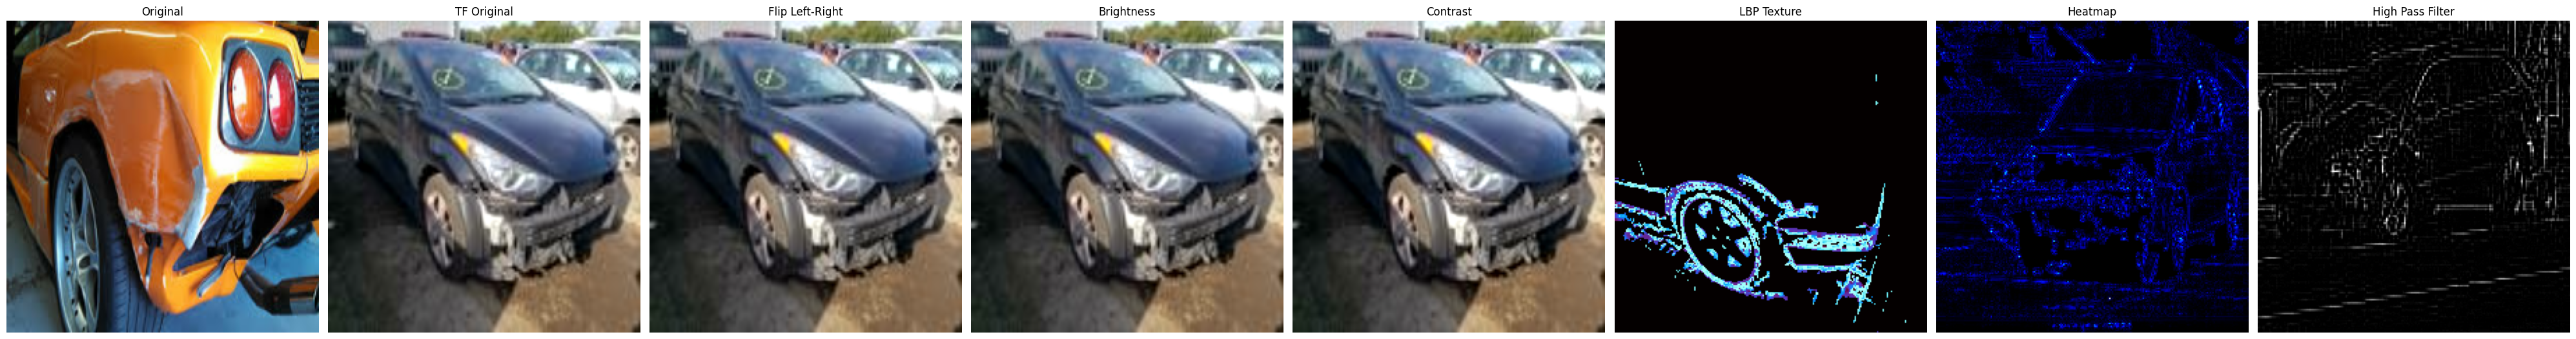

In [26]:
# Fungsi show diubah agar menerima axes dari matplotlib agar semua gambar bisa tampil dalam satu figure
def show_on_axes(ax, title, img):
    ax.axis("off")
    ax.set_title(title)
    # Cek apakah grayscale
    if len(img.shape) == 2 or (len(img.shape) == 3 and img.shape[2] == 1):
        ax.imshow(img.squeeze(), cmap='gray')
    else:
        ax.imshow(img)

def augment_tf_separate(image, label):
    image = tf.image.resize(image, (224, 224))
    original_image = image

    flipped = tf.image.random_flip_left_right(image)
    brightened = tf.image.random_brightness(flipped, max_delta=0.1)
    
    with tf.device('/CPU:0'):
        contrasted = tf.image.random_contrast(brightened, 0.9, 1.1)

    return original_image, flipped, brightened, contrasted, label

for (image_orig, label_orig), \
    (image_tf, _), \
    (image_lbp, _), \
    (image_heatmap, _), \
    (image_highpass, _) in zip(
        train_ds.take(1),
        train_ds_tf.take(1),
        train_ds_lbp.take(1),
        train_ds_heatmap.take(1),
        train_ds_highpass.take(1),
    ):

    orig_tf, flip_tf, bright_tf, contrast_tf, lbl_tf = augment_tf_separate(image_tf, None)

    image_orig = tf.image.resize(image_orig, (224, 224))
    image_orig = tf.cast(image_orig, tf.float32) / 255.0

    orig_tf = tf.clip_by_value(orig_tf / 255.0, 0, 1)
    flip_tf = tf.clip_by_value(flip_tf / 255.0, 0, 1)
    bright_tf = tf.clip_by_value(bright_tf / 255.0, 0, 1)
    contrast_tf = tf.clip_by_value(contrast_tf / 255.0, 0, 1)

    image_lbp = tf.image.convert_image_dtype(image_lbp, dtype=tf.float32)
    image_heatmap = tf.image.convert_image_dtype(image_heatmap, dtype=tf.float32)
    image_highpass = tf.image.convert_image_dtype(image_highpass, dtype=tf.float32)

    # Buat figure dan axes untuk 8 gambar
    fig, axes = plt.subplots(1, 8, figsize=(40, 10))

    # Tampilkan masing-masing gambar di axes yang berbeda
    show_on_axes(axes[0], "Original", image_orig.numpy())
    show_on_axes(axes[1], "TF Original", orig_tf.numpy())
    show_on_axes(axes[2], "Flip Left-Right", flip_tf.numpy())
    show_on_axes(axes[3], "Brightness", bright_tf.numpy())
    show_on_axes(axes[4], "Contrast", contrast_tf.numpy())
    show_on_axes(axes[5], "LBP Texture", image_lbp.numpy())
    show_on_axes(axes[6], "Heatmap", image_heatmap.numpy())
    show_on_axes(axes[7], "High Pass Filter", image_highpass.numpy())

    plt.tight_layout()
    plt.show()

    break  # cukup 1 batch


Hasil di atas adalah salah satu contoh hasil augmentasi yang saya lakukan (flip horizontal, brightness, contrast, LPB Texture, Heatmap dan High Pass Filter)

### B. Data Normalization

Pada Data Normalization saya akan melakukan normalisasi pixel dari 0-255 menjadi 0-1 agar model bisa belajar dengan data yang skalanya sama. Saya menggunakan method image.convert_image_dtype dari tensor flow. Normalisasi adalah standard yang harus dilakukan pada computer vision. Normalisasi juga harus dilakukan setelah data augmentasi selesai. Normalisasi juga dilakukan pada data validation dan data test karena model di training juga menggunakan data yang sudah di normalisasi, kalau skala pixelnya beda-beda maka model tidak bisa membaca data dan memproses datanya. [source](https://www.imaios.com/en/resources/blog/ct-images-normalization-zero-centering-and-standardization)

In [27]:
#Normalisasi (Scalling)
def normalize_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)  # normalisasi ke [0,1]
    return image, label

# Baru normalisasi dataset setelah semua augmentasi selesai
train_ds_combined = train_ds_combined.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)

# Contoh: normalisasi pada data validation
val_ds_normalized = val_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)

# Contoh: normalisasi pada data test
test_ds_normalized = test_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)


### C. Batch Generator

Pada tahap ini tidak ada pasti berapa bacth generator yang bagus untuk data saya, saya akan coba dari batch 16,32 dan 64, lalu membandingkan mana yang terbaik.

In [28]:
#Batch 
batch_size = 16

train_ds_combined = train_ds_combined.batch(batch_size).map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
val_ds_normalized = val_ds.batch(batch_size).map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
test_ds_normalized = test_ds.batch(batch_size).map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

# BAB 6 CNN Training (Sequential API/Functional API)

## 6.1. Model Definition and Model Training

Pada tahap ini saya menggunakan model CNN basic karena model ini efektif untuk mengenali pola dalam gambar seperti kerusakan pada mobil dengan variasi yang berbeda-beda dalam satu kelas. CNN mampu mendeteksi fitur spasial dan tekstur pada gambar secara otomatis melalui beberapa layer konvolusi(COnV2D), sehingga sangat cocok untuk menangkap berbagai macam detail dari kerusakan mobil, seperti baret, penyok, atau hancur lebur.

Model CNN basic ini memiliki struktur yang lebih sederhana tapi cukup fleksibel untuk kebutuhan klasifikasi gambar, dengan beberapa layer Conv2D dan MaxPooling2D yang akan mengekstraksi fitur penting dari gambar tanpa harus membuat model yang kompleks. Dengan pendekatan ini, pola-pola variasi pada data dapat dikenali dengan baik oleh model.
Selain itu, meskipun CNN ini menggunakan API Functional yang memberikan fleksibilitas dalam membangun model, strukturnya tetap berurutan dengan sederhana, jadi mudah dimodifikasi dan dikembangkan jika nanti membutuhkan penyesuaian lebih lanjut. API Functional juga memudahkan pengelolaan alur data yang penting untuk eksperimen-model agar bisa disesuaikan dengan karakteristik dataset saya.
Lebih lengkap tentang penggunaan Functional API untuk membuat model yang fleksibel dapat dipelajari di halaman resmi TensorFlow ini: [Keras Functional API Guide](https://www.tensorflow.org/guide/keras/functional_api)

Sebelum masuk ke hyperparameter yang saya akan gunakan, saya selalu akan menggunakan Syntax: tf.keras.backend.clear_session() dimana untuk membersihkan sesi Keras yang lama agar tidak ada tumpang tindih model atau layer lama yang dapat mengganggu memori dan next execution.

Ini adalah list beberapa hyperparameter yang akan saya gunakan :  
1. Input Layer : pada input layer sama menggunakan shape (224,224, 3) karena ini sesuai dengan file input saya di atas. (224, 224) adalah ukurannya dan (3) mewakili RGB (Red, Green, Blue). Ukuran ini sebenarnya juga standar umum untuk image processing pada ANN dan CNN.
2. Conv2D dan MaxPooling2D : dua layer Conv2D (32 dan 64) yang memungkinkan model belajar fitur yang semakin kompleks dan abstrak secara bertahap dengan kernel size 3x3 dan aktivasi ReLU digunakan untuk ekstraksi fitur penting dari gambar. Relu sifatnya non-linear dan dia membantu menghindari masalah vanishing gradient. Ditambah MaxPooling2D untuk mengecilkan dimensi spasial sehingga mengurangi kompleksitas dan overfitting.
3. Flatten layer : karena ANN hanya bisa menerima input vektor 1D maka shapenya di flatten (digepengkan) yang tadinya 3D (224,224,3) menjadi 1D.
4. Hidden layer : menggunakan dense layer dengan 128 neuron dan ReLU sebagai penghubung (activation function) ke layer output. Angka 128 cukup  untuk mengolah fitur kompleks yang diperoleh CNN.
5. Output layer : menggunakan softmax karena multiclass (kelas lebih dari 2). [source](https://www.kode.id/courses/take/full-time-data-analytics-phase-2/pdfs/46703422-day-1-am-artificial-neural-network-ann-theory) Neuron yang saya gunakan adalah 3 sesuai dengan class dataset saya. 
6. Optimizer : menggunakan adam optimizer karena adaptive, stabil dan biasa digunain di berbagai jenis data [source](https://www.kode.id/courses/take/full-time-data-analytics-phase-2/pdfs/48461148-day-2-pm-training-artificial-neural-network-part-2)
7. Matrix : menggunakan accuracy karena mau melihat semua prediksi kelas harus benar dan tinggi. Penggunaa accuracy juga karena dataset balance.
8. loss : menggunakan sparse_categorical_crossentropy karena labelnya multiclass dan labelnya ordinal [source](https://www.kode.id/courses/take/full-time-data-analytics-phase-2/pdfs/46703422-day-1-am-artificial-neural-network-ann-theory)

Model Training
1. epoch : saya menggunakan epoch 40 agar model punya waktu belajar lebih lama.

In [14]:
# Clear Session 
tf.keras.backend.clear_session()

# Input Layer
inputs = layers.Input(shape=(224, 224, 3), name='input_layer')

# Conv Layer pertama: 32 filter, kernel 3x3, aktivasi ReLU
x = layers.Conv2D(32, (3,3), activation='relu', name='conv2d_32')(inputs)
x = layers.MaxPooling2D((2,2), name='maxpool_1')(x)

# Conv Layer kedua: 64 filter, kernel 3x3, aktivasi ReLU
x = layers.Conv2D(64, (3,3), activation='relu', name='conv2d_64')(x)
x = layers.MaxPooling2D((2,2), name='maxpool_2')(x)

# Flatten layer untuk vektor 1D dari output conv
x = layers.Flatten(name='flatten_layer')(x)

# Dense layer Fully connected dengan 128 neuron dan ReLU
x = layers.Dense(128, activation='relu', name='dense_128_relu')(x)

# Output layer untuk 3 kelas dengan softmax
outputs = layers.Dense(3, activation='softmax', name='output_layer')(x)

# Membuat model CNN
model = models.Model(inputs=inputs, outputs=outputs, name='Basic_CNN')

# Compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Tampilkan ringkasan model
model.summary()

# Training model
history = model.fit(
    train_ds_combined,
    validation_data=val_ds_normalized,
    epochs=40
)

Model: "Basic_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_1 (MaxPooling2D)             │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_64 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_2 (MaxPooling2D)             │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_layer (Flatten)              │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_128_relu (Dense)               │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,907,779 (91.20 MB)

 Trainable params: 23,907,779 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40


2025-06-30 09:29:40.681754: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_11}}
I0000 00:00:1751275784.707627     108 cuda_dnn.cc:529] Loaded cuDNN version 90300


311/311 ━━━━━━━━━━━━━━━━━━━━ 57s 164ms/step - accuracy: 0.3752 - loss: 75.1922 - val_accuracy: 0.4395 - val_loss: 1.1170
Epoch 2/40
311/311 ━━━━━━━━━━━━━━━━━━━━ 52s 163ms/step - accuracy: 0.5248 - loss: 1.0435 - val_accuracy: 0.4556 - val_loss: 1.4412
Epoch 3/40
311/311 ━━━━━━━━━━━━━━━━━━━━ 52s 162ms/step - accuracy: 0.6662 - loss: 0.8699 - val_accuracy: 0.3911 - val_loss: 2.4151
Epoch 4/40
311/311 ━━━━━━━━━━━━━━━━━━━━ 52s 161ms/step - accuracy: 0.7893 - loss: 0.6331 - val_accuracy: 0.4153 - val_loss: 2.7892
Epoch 5/40
311/311 ━━━━━━━━━━━━━━━━━━━━ 52s 162ms/step - accuracy: 0.8446 - loss: 0.5113 - val_accuracy: 0.4113 - val_loss: 1.7403
Epoch 6/40
311/311 ━━━━━━━━━━━━━━━━━━━━ 52s 161ms/step - accuracy: 0.8726 - loss: 0.3401 - val_accuracy: 0.4073 - val_loss: 1.7410
Epoch 7/40
311/311 ━━━━━━━━━━━━━━━━━━━━ 52s 162ms/step - accuracy: 0.9107 - loss: 0.2729 - val_accuracy: 0.4113 - val_loss: 2.3065
Epoch 8/40
311/311 ━━━━━━━━━━━━━━━━━━━━ 52s 163ms/step - accuracy: 0.9241 - loss: 0.2298 - va

## 6.2 Model Evaluation

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

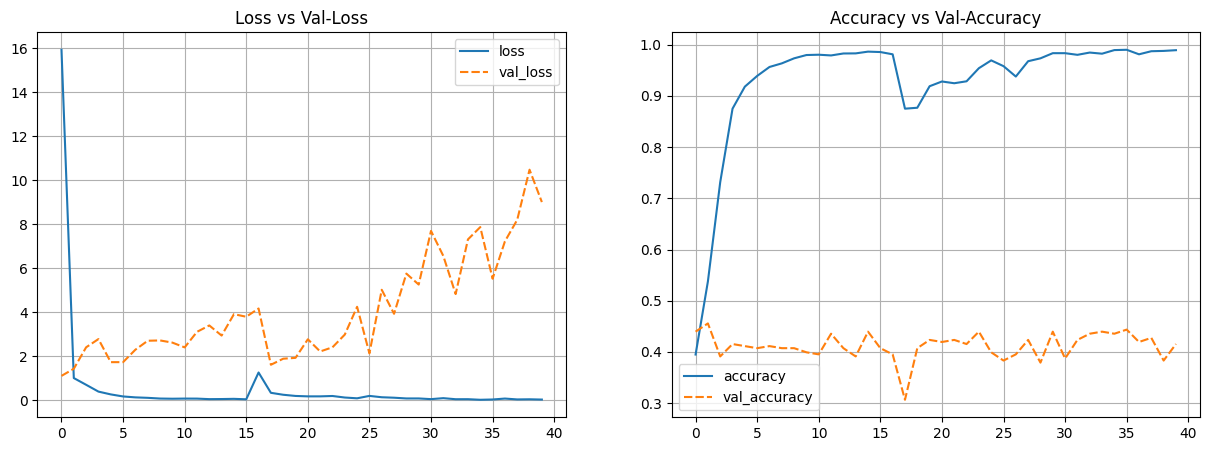

In [16]:
# Plot training results sebelum exprerimen pengurangan gaussian blur, gaussian noise dan random cut out (tolong jangan dirun, nanti hilang)

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

Dari hasil grafik loss vs Val loss, bisa di ambil insight :  
1. Di awal training, validation loss (val_loss) menunjukkan fluktuasi dan kemudian mulai naik perlahan sejak sekitar epoch 14 hingga 26, yang mengindikasikan mulai terjadi overfitting — model belajar terlalu baik pada data train, tapi gagal generalisasi ke data validasi
2. Setelah lonjakan sangat tinggi pada epoch 26, val-loss turun drastis lalu naik dikit di 30 dan kembali turun mendekati nilai yang lebih rendah di epoch 32.
3. Training loss menurun tajam dan kemudian tetap rendah serta stabil hingga akhir training — hal ini menunjukkan bahwa model sangat mudah mempelajari data training..
4. Pola datar di loss training (setelah menurun drastis) menandakan bahwa model telah sangat berhasil belajar pada data train — bahkan mungkin terlalu baik (overfit), karena val_loss malah naik
   
Untuk Accuracy vs Val-Accuracy, bisa diambi insight :
1. Training accuracy naik sangat cepat, mencapai 0.99 pada epoch 10 dan tetap tinggi — ini menunjukkan model sangat cocok pada data train, lagi-lagi indikasi overfitting
2. Val-accuracy cenderung lebih tinggi dibanding accuracy, berkisar dari 0.35 hingga 0.41, dengan fluktuasi yang cukup besar terutama lonjakan pada sekitar epoch 10 dan 38.
3. Pola fluktuasi ini menunjukkan model tidak konsisten dalam performa data validasi, mungkin terjadi karena augmentasi data yang kompleks. 
4. Gap besar antara train acc dan val acc, serta fluktuasi tinggi pada val acc, menunjukkan overfitting dan potensi data leakage atau noise tinggi di data validasi 


Kesimpulan :
- Model mengalami overfitting. Terlihat dari training loss yang sangat rendah dan akurasi training yang mendekati 1.0, sedangkan val_loss malah naik dan val_accuracy tetap rendah serta fluktuatif
- Overfitting kemungkinan disebabkan oleh model terlalu kompleks, jumlah data terlalu sedikit, atau augmentasi yang tidak efektif di validasi.
- Seharusnya bisa menggunakan early-stopping karena di epoch 14 - 18 ketika val loss masih rendah dan belum ada lonjakan. Supaya tidak ada pemborosan resource.


In [18]:
# Prediksi probabilitas
y_pred_prob_train = model.predict(train_ds_combined)
y_pred_prob_test = model.predict(test_ds_normalized)

# Prediksi kelas dengan probabilitas tertinggi
y_pred_class_train = np.argmax(y_pred_prob_train, axis=-1)
y_pred_class_test = np.argmax(y_pred_prob_test, axis=-1)

# Ekstrak label asli dari dataset
true_labels_train = np.concatenate([y.numpy() for x, y in train_ds_combined], axis=0)
true_labels_test = np.concatenate([y.numpy() for x, y in test_ds_normalized], axis=0)

# Nama kelas 
class_names = ['01-minor', '02-moderate', '03-severe'] 

# Tampilkan classification report
print("Classification Report Data Train")
print(classification_report(true_labels_train, y_pred_class_train, target_names=class_names))
print("-"*52)
print("Classification Report Data Test")
print(classification_report(true_labels_test, y_pred_class_test, target_names=class_names))

311/311 ━━━━━━━━━━━━━━━━━━━━ 44s 137ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Classification Report Data Train
              precision    recall  f1-score   support

    01-minor       0.33      0.33      0.33      1624
 02-moderate       0.33      0.33      0.33      1664
   03-severe       0.35      0.35      0.35      1684

    accuracy                           0.34      4972
   macro avg       0.34      0.34      0.34      4972
weighted avg       0.34      0.34      0.34      4972

----------------------------------------------------
Classification Report Data Test
              precision    recall  f1-score   support

    01-minor       0.41      0.48      0.44        46
 02-moderate       0.39      0.30      0.34        47
   03-severe       0.38      0.40      0.39        47

    accuracy                           0.39       140
   macro avg       0.39      0.39      0.39       140
weighted avg       0.39      0.39      0.39       140



Dari hasil Classification Report di atas, saya dapat mengambil beberapa insight penting:

1. Model menunjukkan performa yang hampir merata di semua kelas dengan accuracy di kisaran 34% - 39%, menandakan bahwa prediksi model tidak terlalu bias ke kelas tertentu, walaupun nilai precision, recall, dan f1-score untuk masing-masing kelas masih relatif rendah. Ini menandakan model belum optimal dalam mengenali pola spesifik untuk tiap kelas, namun sudah ada distribusi prediksi yang tersebar cukup merata.
2. Nilai recall dan f1-score pada kelas minor, moderate, dan severe berada di angka yang sama-sama rendah (sekitar 0.33–0.40), yang menunjukkan bahwa model belum cukup baik dalam mengidentifikasi true positive dengan akurasi tinggi di tiap kelas, meskipun prediksi tidak condong pada satu kelas saja.
3. Akurasi keseluruhan pada data training adalah sekitar 34%, dan pada data testing membaik sedikit menjadi 39%, menandakan ada tren peningkatan performa walaupun masih jauh dari angka ideal. Ini menunjukkan model masih perlu perbaikan untuk mendapatkan prediksi benar yang lebih konsisten di seluruh kelas.
4. Berdasarkan pola ini, dapat disimpulkan model mengalami underfitting, karena nilai accuracy dan metrik lain yang minimal pada data training mengindikasikan model belum belajar secara efektif, sehingga belum mampu memetakan perbedaan pola ketiga kelas dengan baik untuk mendapatkan true positive yang maksimal.
5. Overall Berdasarkan hasil diatas, saya nyatakan model pertama ini UNDERFIT.

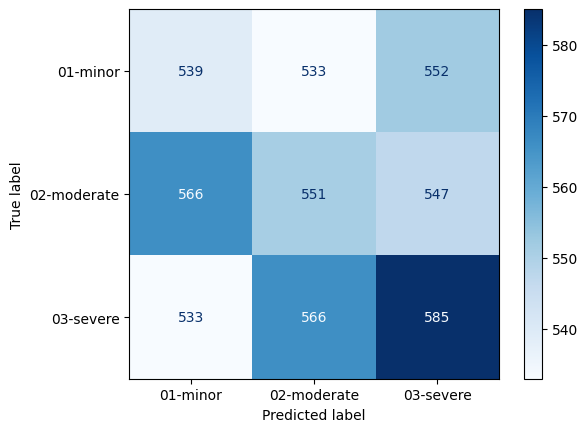

In [19]:
#Confusion Matrix Data Train
cm_train = confusion_matrix(true_labels_train, y_pred_class_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Pada heatmap confusion matrix di atas bisa saya simpulkan hasilnya sesuai dengan confusion matrix, dimana model masih sangat kebingungan membedakan tiap kelas.

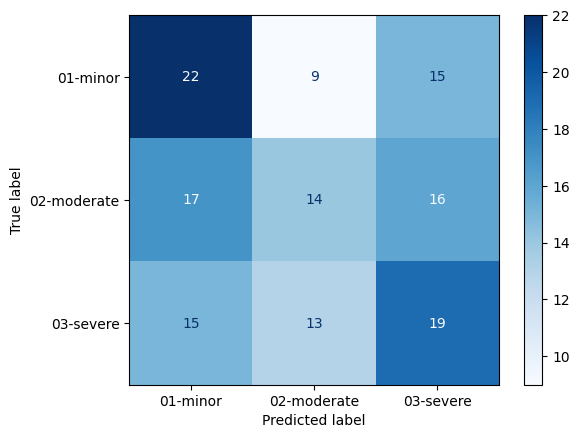

In [20]:
#Confusion Matrix Data Test
cm_test = confusion_matrix(true_labels_test, y_pred_class_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dari heatmap diatas bisa saya simpulkan bahwa mau heatmap ataupun classification report data test sama-sama menegaskan bahwa model perlu perbaikan karena kesulitan dalam membedakan kelas minor, moderate, dan severe dengan tepat.

Kesimpulan akhir model :
1. Ada ketidaksesuaian antara indikasi overfitting dan underfitting
   - Line diagram (grafik loss dan accuracy) menunjukkan gejala overfitting, yaitu training loss sangat kecil dan akurasi sangat tinggi, tetapi validation loss naik dan validation accuracy rendah.
   - Akan tetapi accurasy yang lebih tinggi di data test (39% di datatest dan 35% di data train)  mengindikasikan underfitting, dimana model belum mampu mengenali pola data secara optimal
2. Hal itu bisa terjadi karena model terlalu sederhana jadi belum bisa belajar dengan optimal
3. Perbedaan antara kelas yang sulit dibedakan, dimana konteksnya disini adalah kerusakan mobil
   - Perbedaan antar kelas (minor, moderate, severe kerusakan mobil) sulit dideteksi dengan jelas oleh model.
   - Hal ini juga dipengaruhi oleh kualitas data, fitur, dan label yang mungkin kurang mendukung pemisahan kelas yang baik.
4. Akan dilakukan model improvement dengan tuning hyperparameter lalu akan di evaluasi ulang

# BAB 7 CNN Improvement (Sequential API/Functional API)

## 7.1 Model Definition dan Model Training


Pada tahap ini saya akan improve CNN basic menggunakan beberapa hyperparameter dan penambahan fitur lain. Beberapa fungsi yang saya gunakan, yaitu :
1. Tf.keras.backend.clear_session : Seperti dimodel sebelumnya saya memulai model definition dengan clear session dan seed terlebih dahulu, dimana ini untuk menghindari konflik dan menghindari momory leak. Untuk jumlah seed sudah di definisikan di awal
2. Model Pre-Train :
   - Saya menggunakan model pre-train karena memang untuk efesiensi waktu dan sumber daya terbatas, dimana kalau menggunakan TPU, kaggle cuma kasih 30 jam per weeknya.
   - Device saya juga tidak mumpuni kalau ingin training di device lokal
   - Dengan model pre-train juga pasti membuat performa lebih baik daripada bangun CNN dari awal
   - Saya menggunakan ResNet50V2 karena dataset yang saya gunakan mempunyai kompleksitas visual yang tinggi, dimana sulit membedakan tiap kelas. Penggunaan model ini saya harap bisa memberikan balance antara performa dan stabilitas
   - Model ResNet50V2 lebih mudah di tune tanpa menyesuaikan banyak hyperparameter dibanding EffecientNet dan model lain.
   - Untuk weight di model ini saya menggunakan 'imagenet' supaya weight pretrained pada Imagenet digunakan
3. Fine tune layer: Saya melakukan fine-tuning di 30 % layer terakhir, jadi 70% layer awal langsung digunakan. 
4. Input Layer :
   - Shapenya tetap di (224,224,3) sesuai dengan base model
   - Setiap dense menggunakan ReLu untuk activation functionnya dan ada regularisasi learning rate di 1e-4 supaya terhindar dari overfitting
   - Melakukan batch normalization dimana untuk mengatur output agar distribusi lebih stabil dan model jadi lebih cepat ketika training [source](https://arxiv.org/pdf/1502.03167)
   - Menggunakan Global Average Pooling dimana method ini adalah bekerja dengan mengambil rata-rata dari setiap fitur dalam gambar yang di proses sebelumnya, sehingga informasi penting akan diringkas jadi satu baris vektor saja. Hal itu membuat model jadi lebih ringan dan cepat belajar, serta mengurangi overfitting [source](https://arxiv.org/pdf/1312.4400)
5. Hidden Layer :
   - Untuk hidden layer disini menggunakan neuron yang yang lebih tinggi yaitu  image processing yaitu (512, 256, dan 128) dengan batch normalization setiap setelah penerapan activation function
   - Ditambahkan dropout dengan rate berbeda untuk menghindari overfitting: 0.4, 0.3, dan 0.2.
6. Output Layer : Disini saya masih menggunakan softmax dimana memang di peruntukan untuk multiclass
7. Compile :
   - Menggunakan Adam optimizer seperti di CNN basic tapi learning ratenya di perkecil  di 1e-4 agar update weight perlahan dan tidak tiba-tiba berubah terlalu banyak
   - Loss function sparse_categorical_crossentropy cocok dengan target label nominal (0,1,2)
   - Matricnya "accuracy" karena masih mau melihat porsi tiap kelas yang tinggi
8. Callback pada training :
   - EarlyStopping yang akan menghentikan training jika val-loss tidak membaik selama 6 epoch
   - ReduceLROnPlateu yang akan menurunkan learning rate jika val-loss juga tidak membaik selama 3 epoch dengan minimum di learning rate 1e-6.
   - Menggunakan Checkpoint sehingga menyimpan model terbaik selama training (berdasarkan matriks validasi) dimana jika terjadi gangguan, model terbaik tetap tersimpan
   [source](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks)

Model Training
1. Menggunakan epoch 40
2. Menggunakan Callback (EarlyStopping, ReduceLROnPlateu dan Checkpoint)

In [29]:
# Clear session & seed
tf.keras.backend.clear_session()

# Load ResNet50V2 base model tanpa top layer
base_model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Fine-tuning: freeze semua layer kecuali 30% terakhir
total_layers = len(base_model.layers)
freeze_until = int(total_layers * 0.7)
for layer in base_model.layers[:freeze_until]:
    layer.trainable = False
for layer in base_model.layers[freeze_until:]:
    layer.trainable = True

# Input Layer
inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=True)
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling2D()(x)

# Hidden Layers dengan Dropout dan Batch Normalization
x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

# Output layer
outputs = layers.Dense(3, activation='softmax')(x)

# Model akhir
model_resnet = models.Model(inputs=inputs, outputs=outputs)

# Compile
model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callback EarlyStopping, ReduceLROnPlateau dan ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_model_resnet50v2_fine_tuned.h5', monitor='val_loss', save_best_only=True)

# Model summary
model_resnet.summary()

# Training
history_resnet = model_resnet.fit(
    train_ds_combined,
    validation_data=val_ds_normalized,
    epochs=40,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 7, 7, 2048)          │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,790,275 (94.57 MB)

 Trainable params: 18,424,835 (70.29 MB)

 Non-trainable params: 6,365,440 (24.28 MB)

Epoch 1/40


2025-07-01 12:50:12.385261: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_11}}
I0000 00:00:1751374240.363202     110 cuda_dnn.cc:529] Loaded cuDNN version 90300


311/311 ━━━━━━━━━━━━━━━━━━━━ 107s 245ms/step - accuracy: 0.3491 - loss: 1.7105 - val_accuracy: 0.3750 - val_loss: 4.9353 - learning_rate: 1.0000e-04
Epoch 2/40
311/311 ━━━━━━━━━━━━━━━━━━━━ 74s 233ms/step - accuracy: 0.3769 - loss: 1.5436 - val_accuracy: 0.4435 - val_loss: 5.2457 - learning_rate: 1.0000e-04
Epoch 3/40
311/311 ━━━━━━━━━━━━━━━━━━━━ 73s 232ms/step - accuracy: 0.3955 - loss: 1.4493 - val_accuracy: 0.2903 - val_loss: 9.1632 - learning_rate: 1.0000e-04
Epoch 4/40
311/311 ━━━━━━━━━━━━━━━━━━━━ 74s 233ms/step - accuracy: 0.3907 - loss: 1.4088 - val_accuracy: 0.3185 - val_loss: 4.9377 - learning_rate: 1.0000e-04
Epoch 5/40
311/311 ━━━━━━━━━━━━━━━━━━━━ 74s 232ms/step - accuracy: 0.3901 - loss: 1.3854 - val_accuracy: 0.3105 - val_loss: 9.0035 - learning_rate: 3.0000e-05
Epoch 6/40
311/311 ━━━━━━━━━━━━━━━━━━━━ 74s 232ms/step - accuracy: 0.3951 - loss: 1.3650 - val_accuracy: 0.2984 - val_loss: 5.0449 - learning_rate: 3.0000e-05
Epoch 7/40
311/311 ━━━━━━━━━━━━━━━━━━━━ 73s 232ms/step -

## 7.2 Model Evaluation
Evaluasi performa versi improved
Visualisasi dan analisis perbandingan dengan model sebelumnya

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

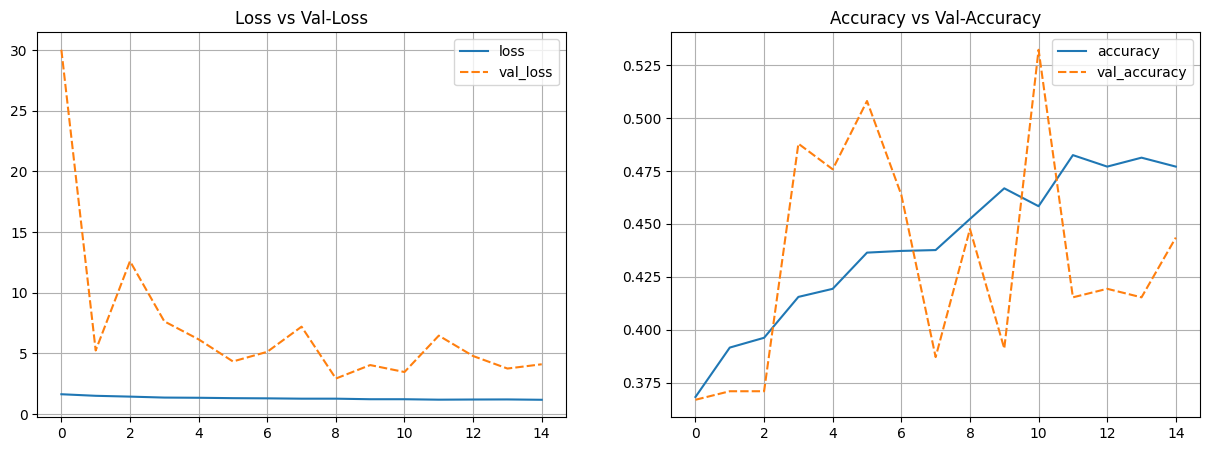

In [34]:
# Plot training results model_resnet

history_resnet_df= pd.DataFrame(history_resnet.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_resnet_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_resnet_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

Insight dari Grafik Loss vs Val-Loss
1. Training-Loss (garis biru) menunjukkan penurunan yang konsisten dan stabil, yang artinya model belajar pada data training dengan baik.
2. Validation-Loss (garis oranye putus-putus) sangat fluktuatif dan setelah beberapa epoch turun naik naik turun, walau cenderung berada di nilai yang lebih tinggi daripada training-loss. Ini menandakan model tidak cukup generalisasi dengan baik ke data validasi.
3. Perbedaan signifikan antara loss training dan loss validasi menunjukkan adanya overfitting, di mana model bisa jadi "menghafal" data training.
   
Insight dari Grafik Accuracy vs Val-Accuracy
1. Akurasi training meningkat perlahan dan stabil, mencerminkan peningkatan performa model terhadap data training.
2. Akurasi validasi terlalu tidak stabil dan fluktuasinya sangat tinggi. Ada beberapa epoch di mana val accuracy naik drastis, tapi tidak bertahan lama dan kembali turun.
3. Fluktuasi ini juga mengindikasikan bahwa model tidak cukup stabil untuk memprediksi data baru dan kemungkinan overfit.

Jika dibandingkan dengan model sebelum tuning, secara keseluruhan ini lebih baik walaupun memang masih dalam kategori overfitting.


In [35]:
# Prediksi probabilitas
y_pred_prob_train_2 = model_resnet.predict(train_ds_combined)
y_pred_prob_test_2 = model_resnet.predict(test_ds_normalized)

# Prediksi kelas dengan probabilitas tertinggi
y_pred_class_train_2 = np.argmax(y_pred_prob_train_2, axis=-1)
y_pred_class_test_2 = np.argmax(y_pred_prob_test_2, axis=-1)

# Ekstrak label asli dari dataset
true_labels_train = np.concatenate([y.numpy() for x, y in train_ds_combined], axis=0)
true_labels_test = np.concatenate([y.numpy() for x, y in test_ds_normalized], axis=0)

# Nama kelas 
class_names = ['01-minor', '02-moderate', '03-severe'] 

# Tampilkan classification report
print("Classification Report Data Train : ")
print(classification_report(true_labels_train, y_pred_class_train_2, target_names=class_names))
print('-' * 52)
print("Classification Report Data Test")
print(classification_report(true_labels_test, y_pred_class_test_2, target_names=class_names))

311/311 ━━━━━━━━━━━━━━━━━━━━ 63s 190ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
Classification Report Data Train : 
              precision    recall  f1-score   support

    01-minor       0.31      0.13      0.19      1624
 02-moderate       0.34      0.81      0.47      1664
   03-severe       0.33      0.05      0.09      1684

    accuracy                           0.33      4972
   macro avg       0.33      0.33      0.25      4972
weighted avg       0.33      0.33      0.25      4972

----------------------------------------------------
Classification Report Data Test
              precision    recall  f1-score   support

    01-minor       0.44      0.76      0.56        46
 02-moderate       0.34      0.26      0.29        47
   03-severe       0.54      0.30      0.38        47

    accuracy                           0.44       140
   macro avg       0.44      0.44      0.41       140
weighted avg       0.44      0.44      0.41       140



Insigt dari Matrix Classification Report diatas : 
1. Accuracy Test meningkat dari 39% ke 44% setelah tuning, yang menunjukkan model menjadi lebih baik dalam mengeneralisasi pada data test.
2. Accuracy Train sedikit menurun dari 34% ke 33%, yang sebenarnya bisa menjadi indikasi bahwa tuning mengurangi overfitting model pada data train, atau mungkin model lebih fokus pada generalisasi ketimbang hanya "hapalan" data train.
3. Secara keseluruhan, improvisasi accuracy test jauh lebih penting karena memastikan model dapat bekerja lebih baik pada data tak terlihat.


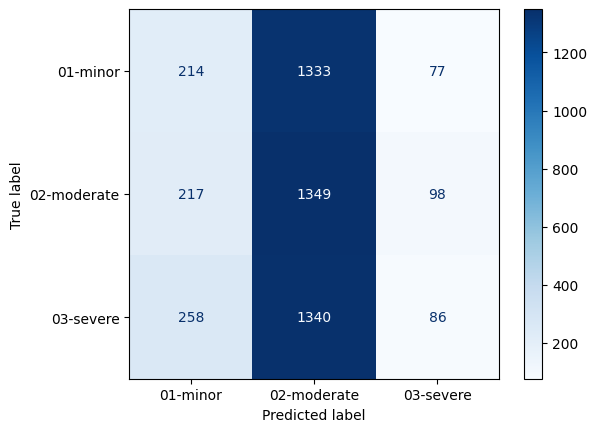

In [38]:
#Data Train
cm = confusion_matrix(true_labels_train, y_pred_class_train_2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Insight dari heatmap diatas pada data train adalah : 
- Sebagian besar prediksi model banyak menebak kelas '02-moderate' dibanding kelas sebenarnya (lihat nilai tinggi 1333, 1349, 1340 pada kolom moderate), terlepas dari kelas asli (minor, moderate, severe).
- Model memiliki bias prediksi kuat ke kelas '02-moderate', ini menandakan model tidak mempelajari dengan cukup baik perbedaan antar kelas.
- Hal ini juga tercermin pada recall rendah untuk kelas minor (0.13) dan severe (0.05) kalau mengacu pada value di confusion matrixnya, sedangkan moderate recall lebih tinggi (0.81), menunjukkan model “terjebak” mendeteksi kelas moderate lebih sering.

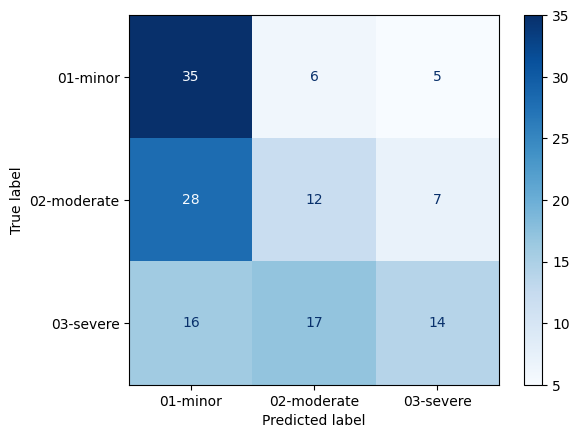

In [39]:
#Data Train
cm = confusion_matrix(true_labels_test, y_pred_class_test_2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Insight dari heatmap di atas pada data test adalah : 
- Kelas minor paling banyak diklasifikasikan dengan benar (35 benar minor), tapi ada 6 sampel minor yang diprediksi moderate, dan 5 yang diprediksi severe.
- Kelas moderate kurang baik, hanya 12 prediksi yang benar dari 47 sampel. Sebanyak 28 sampel moderate diprediksi sebagai minor, dan 7 sebagai severe.
- Kelas severe juga kurang baik, hanya 17 benar dari 47, dengan 16 sampel diprediksi minor dan 14 diprediksi moderate.

Model terbaiknya adalah model kedua (MODEL SETELAH DI TUNING), walaupun model kedua tetap underfit. Akan tetapi performa di data testnya jauh lebih baik daripada model pertama dimana pada model kedua terlihat adanya peningkatan signifikan pada akurasi data test yang mencapai 0.44 dibanding model pertama yang hanya sekitar 0.39. Selain itu, confusion matrix dan classification report pada data test model kedua menunjukkan distribusi prediksi yang lebih seimbang dan recall yang lebih baik pada kelas minor dan severe, meskipun secara keseluruhan model ini underfit pada data train dengan akurasi rendah dan loss yang lebih stabil, namun fokus utama adalah performa pada data test yang mencerminkan kemampuan generalisasi model. Secara general kedua model underfit, tapi saya memutuskan pilih yang model kedua karena lebih baik pada datatest.

## BAB 8 Model Saving



In [30]:
#Save model
model_resnet.save('model_cnn_crash_car.keras')

# BAB 9 Model Inference

Model inference ada di repository yang sama. Nama file inferencenya adalah P2G7_Inference.ipynb

# BAB 10 Pengambilan Kesimpulan

Kesimpulan Model

1. Model CNN dasar dapat digunakan untuk klasifikasi kerusakan mobil ke dalam tiga kategori, namun perlu perhatian khusus terhadap dataset dan tuning model.
2. Meskipun model underfit, model kedua tetap dipilih sebagai yang terbaik karena performa data testnya relatif lebih baik.
3. Terdapat perbedaan signifikan antar kelas kerusakan yang bisa dikenali oleh model, walau model masih terbatas.
4. Evaluasi menunjukkan bahwa kelas moderate perlu perhatian lebih karena prediksinya masih kurang akurat dibanding kelas minor dan severe.
5. Overall model masih ***UNDERFIT*** jadi memerlukan pengambangan lebih lanjut
   
Rekomendasi Model
1. Eksplorasi Arsitektur Transformer untuk Vision: Selain CNN seperti ResNet, coba eksplorasi model berbasis transformer untuk pengolahan gambar seperti Vision Transformers (ViT) atau hybrid CNN-ViT. Model ini kini menunjukkan hasil sangat baik dalam klasifikasi citra dengan fitur representasi yang kuat.
2. Fine-tuning dengan Learning Rate Scheduling Lebih Agresif: Gunakan learning rate warm-up di awal training dan cyclic learning rate untuk eksplorasi learning rate optimal, ini dapat membantu model keluar dari local minima dan belajar lebih efektif.
3. Penambahan Lapisan Attention pada CNN: Tambahkan modul attention seperti SE-Block (Squeeze-and-Excitation) atau CBAM untuk memperkuat kemampuan model memfokuskan pada fitur penting yang relevan dengan kelas kerusakan.

Rekomendasi Bisnis

Model ini belum layak pakai maka dari itu diperlukan explorasi lanjutan seperti eksplor augmentansi metode lain, melakukan filter di kelas secara manual, dimana gambar-gambar di tiap kelas harus lebih clear lagi masuk ke kelasnya. Lalu untuk perbedaan kelas moderata dan severe juga harus lebih obvious lagi perbedaanya. 






